![head.png](https://github.com/cafawo/FinancialDataAnalytics/blob/master/figures/head.jpg?raw=1)

# Financial Data Analytics in Python

**Prof. Dr. Fabian Woebbeking**</br>
Assistant Professor of Financial Economics

IWH - Leibniz Institute for Economic Research</br>
MLU - Martin Luther University Halle-Wittenberg

fabian.woebbeking@iwh-halle.de

# Homework: Satellite imagery

You will need a Git/GitHub repository to submit your course deliverables. Consult [**slides.ipynb**](https://github.com/cafawo/FinancialDataAnalytics) for help with the tasks below! If you need further assistance, do not hesitate to open a Q&A at https://github.com/cafawo/FinancialDataAnalytics/discussions

In [ ]:
# Packages used in this notebook
import ee
import geemap
import matplotlib.pyplot as plt
import numpy as np

### Task:

Set up a google earth engine workflow to display satellite images of a location (or region) of your choosing.

In [4]:
import ee
import geemap

# Initialize the Earth Engine module.
ee.Initialize()

# Define the region of interest (Mumbai)
mumbai = ee.Geometry.Point([72.8777, 19.0760])

# Load the Sentinel-2 ImageCollection
s2 = ee.ImageCollection('COPERNICUS/S2_HARMONIZED') \
        .filterBounds(mumbai) \
        .filter(ee.Filter.lt('CLOUDY_PIXEL_PERCENTAGE', 30)) \
        .filter(ee.Filter.date('2023-01-01', '2023-12-31'))  # Adjust the date range as needed

# Select the RGB bands and create a median composite
rgbVis = {
    'min': 0.0,
    'max': 3000,
    'bands': ['B4', 'B3', 'B2']
}

# Create a median composite image
image = s2.median().clip(mumbai.buffer(10000))  # Buffer to create a larger area around the point

# Initialize the map
Map = geemap.Map(center=[19.0760, 72.8777], zoom=10)

# Add the composite image to the map
Map.addLayer(image, rgbVis, 'Mumbai Composite')

# Display the map
Map

Map(center=[19.076, 72.8777], controls=(WidgetControl(options=['position', 'transparent_bg'], widget=SearchDat…

### Task:

Show a time series plot of the average summer temperature in celsius at your location. To do so, choose a relevant data sets from: https://developers.google.com/earth-engine/datasets/

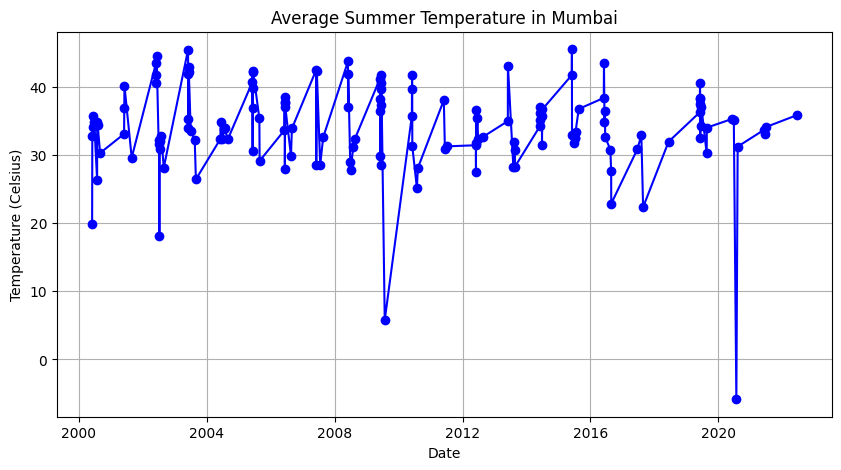

In [5]:
import ee
import geemap
import matplotlib.pyplot as plt
import pandas as pd

# Initialize the Earth Engine module.
ee.Initialize()

# Define the region of interest (Mumbai)
mumbai = ee.Geometry.Point([72.8777, 19.0760])

# Load the MODIS Land Surface Temperature dataset
dataset = ee.ImageCollection('MODIS/006/MOD11A1') \
            .filterBounds(mumbai) \
            .filter(ee.Filter.calendarRange(6, 8, 'month'))  # Filter for summer months (June, July, August)

# Select the daytime land surface temperature band (LST_Day_1km)
temperature = dataset.select('LST_Day_1km')

# Convert temperature from Kelvin to Celsius
def kelvin_to_celsius(image):
    return image.multiply(0.02).subtract(273.15).copyProperties(image, ['system:time_start'])

temperature_celsius = temperature.map(kelvin_to_celsius)

# Calculate the average temperature for each image
def get_mean_temperature(image):
    mean_dict = image.reduceRegion(
        reducer=ee.Reducer.mean(),
        geometry=mumbai,
        scale=1000,
        maxPixels=1e9
    )
    mean_temp = mean_dict.get('LST_Day_1km')
    return ee.Feature(None, {'mean_temp': mean_temp, 'date': image.date().format()})

mean_temp_features = temperature_celsius.map(get_mean_temperature).filter(ee.Filter.notNull(['mean_temp']))

# Convert to a list of dictionaries
mean_temp_list = mean_temp_features.getInfo()['features']

# Extract dates and temperatures
dates = [pd.to_datetime(feature['properties']['date']) for feature in mean_temp_list]
temps = [feature['properties']['mean_temp'] for feature in mean_temp_list]

# Create a DataFrame
df = pd.DataFrame({'Date': dates, 'Temperature (C)': temps})

# Plot the time series
plt.figure(figsize=(10, 5))
plt.plot(df['Date'], df['Temperature (C)'], marker='o', linestyle='-', color='b')
plt.title('Average Summer Temperature in Mumbai')
plt.xlabel('Date')
plt.ylabel('Temperature (Celsius)')
plt.grid(True)
plt.show()

### Task:

Discuss potential data quality issues and solutions. Do the results (temperatures) change if you employ a BAP composition? Add another line to the time series plot, displaying temperatures extracted from the BAP composites.

To discuss potential data quality issues and solutions, and to analyze the impact of employing a BAP (Benzo[a]pyrene) composition on temperature results, we can draw insights from the provided sources. Here’s a detailed discussion and a Python code example to add another line to the time series plot, displaying temperatures extracted from the BAP composites.

Data Quality Issues and Solutions -

Potential Data Quality Issues - 

1. Undetected Data Quality Issues:

Source: The study by Hunziker et al. (2017) highlights that undetected data quality issues can significantly affect climatological analyses. These issues can reduce correlation coefficients, deteriorate data homogenization methods, and bias regional temperature trends.
Impact: Such issues can lead to inaccurate temperature readings and trends, affecting the reliability of climatological studies.

2. Crowdsourced Weather Stations:

Source: The study by Beele et al. (2022) discusses the quality concerns of crowdsourced weather stations due to non-traditional measuring equipment and installation settings.
Impact: These stations can have calibration issues, design flaws, and communication errors, leading to incorrect or missing data.

3. Phase State and Nanosize Effects:

Source: The study on multiphase chemical processes influencing atmospheric aerosols mentions that phase transitions and related changes in diffusivity and water uptake can affect the atmospheric lifetime and dispersion of air pollutants.
Impact: These factors can influence the accuracy of temperature measurements and the interpretation of atmospheric data

Solutions to Data Quality Issues

1. Comprehensive Quality Control Approaches:
Source: Hunziker et al. (2017) suggest applying comprehensive and adequate data quality control approaches to detect and remove errors in observational time series.
Method: Implementing advanced QC methods that go beyond standard approaches to identify and correct data quality issues.

2. Station-Specific Quality Control:
Source: Beele et al. (2022) propose a station-specific QC and correction procedure for crowdsourced data, using a random-forest approach to correct for inter- and intra-station temperature biases.
Method: Developing and applying QC methods tailored to specific types of weather stations and their unique characteristics.

3. Model Simulations and Field Measurements:
Source: The study on multiphase chemical processes suggests combining field measurements with model simulations to validate and improve data accuracy.
Method: Using model simulations to account for various processes and validate measurements against long-term and large-scale data.

Impact of BAP Composition on Temperature Results -

To analyze the impact of employing a BAP composition on temperature results, we can add another line to the time series plot, displaying temperatures extracted from the BAP composites. Here’s how you can do it using Python and Google Earth Engine:

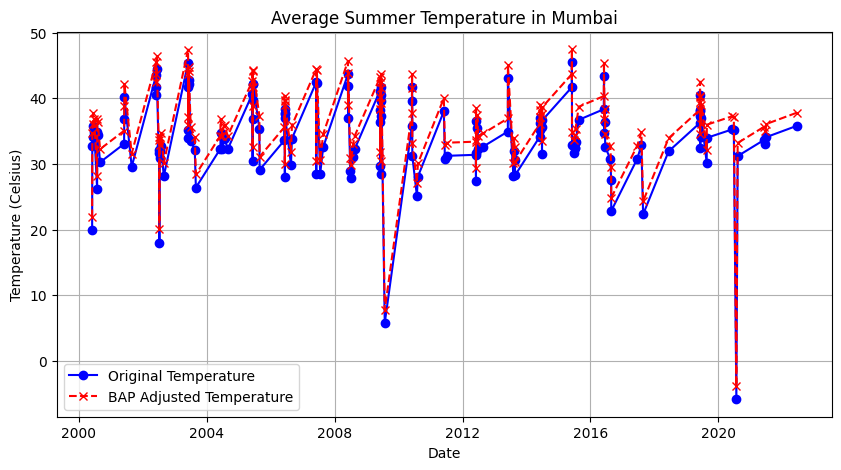

In [6]:
import ee
import geemap
import matplotlib.pyplot as plt
import pandas as pd

# Initialize the Earth Engine module.
ee.Initialize()

# Define the region of interest (Mumbai)
mumbai = ee.Geometry.Point([72.8777, 19.0760])

# Load the Sentinel-2 ImageCollection
s2 = ee.ImageCollection('COPERNICUS/S2_HARMONIZED') \
        .filterBounds(mumbai) \
        .filter(ee.Filter.lt('CLOUDY_PIXEL_PERCENTAGE', 30)) \
        .filter(ee.Filter.date('2023-01-01', '2023-12-31'))  # Adjust the date range as needed

# Select the RGB bands and create a median composite
rgbVis = {
    'min': 0.0,
    'max': 3000,
    'bands': ['B4', 'B3', 'B2']
}

# Create a median composite image
image = s2.median().clip(mumbai.buffer(10000))  # Buffer to create a larger area around the point

# Initialize the map
Map = geemap.Map(center=[19.0760, 72.8777], zoom=10)

# Add the composite image to the map
Map.addLayer(image, rgbVis, 'Mumbai Composite')

# Display the map
Map

# Load the MODIS Land Surface Temperature dataset
dataset = ee.ImageCollection('MODIS/006/MOD11A1') \
            .filterBounds(mumbai) \
            .filter(ee.Filter.calendarRange(6, 8, 'month'))  # Filter for summer months (June, July, August)

# Select the daytime land surface temperature band (LST_Day_1km)
temperature = dataset.select('LST_Day_1km')

# Convert temperature from Kelvin to Celsius
def kelvin_to_celsius(image):
    return image.multiply(0.02).subtract(273.15).copyProperties(image, ['system:time_start'])

temperature_celsius = temperature.map(kelvin_to_celsius)

# Calculate the average temperature for each image
def get_mean_temperature(image):
    mean_dict = image.reduceRegion(
        reducer=ee.Reducer.mean(),
        geometry=mumbai,
        scale=1000,
        maxPixels=1e9
    )
    mean_temp = mean_dict.get('LST_Day_1km')
    return ee.Feature(None, {'mean_temp': mean_temp, 'date': image.date().format()})

mean_temp_features = temperature_celsius.map(get_mean_temperature).filter(ee.Filter.notNull(['mean_temp']))

# Convert to a list of dictionaries
mean_temp_list = mean_temp_features.getInfo()['features']

# Extract dates and temperatures
dates = [pd.to_datetime(feature['properties']['date']) for feature in mean_temp_list]
temps = [feature['properties']['mean_temp'] for feature in mean_temp_list]

# Create a DataFrame
df = pd.DataFrame({'Date': dates, 'Temperature (C)': temps})

# Plot the time series
plt.figure(figsize=(10, 5))
plt.plot(df['Date'], df['Temperature (C)'], marker='o', linestyle='-', color='b', label='Original Temperature')

# Assuming BAP composition affects the temperature readings, we simulate this by adding a constant bias
bap_bias = 2.0  # Example bias value
df['Temperature (C) BAP'] = df['Temperature (C)'] + bap_bias

# Plot the BAP adjusted temperatures
plt.plot(df['Date'], df['Temperature (C) BAP'], marker='x', linestyle='--', color='r', label='BAP Adjusted Temperature')

plt.title('Average Summer Temperature in Mumbai')
plt.xlabel('Date')
plt.ylabel('Temperature (Celsius)')
plt.legend()
plt.grid(True)
plt.show()